<a href="https://colab.research.google.com/github/qutren2108/Sustainability_LC-NC/blob/main/Waste_Reporting_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import networkx as nx

# just trying out waste reporting flow
G = nx.DiGraph()

# list of tasks
tasks = {
    1: "Log new waste item",
    2: "Validate entry",
    3: "Classify waste type",
    4: "Calculate disposal method",
    5: "Assign pickup schedule",
    6: "Summarize total waste",
    7: "Generate compliance report"
}

# add tasks as graph nodes
for t in tasks:
    G.add_node(t, label=tasks[t])

# connect tasks based on flow
edges = [
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 6),
    (4, 5),
    (6, 7)
]
G.add_edges_from(edges)


In [11]:
import random

# assign some dummy time and cpu usage for each task
for n in G.nodes():
    G.nodes[n]['exec_time'] = round(random.uniform(2, 8), 2)     # in seconds
    G.nodes[n]['cpu'] = round(random.uniform(0.2, 0.9), 2)       # as % of 1 CPU

# just to check what it looks like
for n in G.nodes(data=True):
    print(f"{n[1]['label']} → Time: {n[1]['exec_time']}s, CPU: {n[1]['cpu']}")


Log new waste item → Time: 6.41s, CPU: 0.34
Validate entry → Time: 2.7s, CPU: 0.36
Classify waste type → Time: 4.41s, CPU: 0.52
Calculate disposal method → Time: 5.68s, CPU: 0.66
Assign pickup schedule → Time: 5.08s, CPU: 0.41
Summarize total waste → Time: 3.83s, CPU: 0.43
Generate compliance report → Time: 7.47s, CPU: 0.6


In [12]:
import pandas as pd

# sort tasks in execution order (based on DAG)
order = list(nx.topological_sort(G))

# keep track of time and energy
total_time = 0
total_energy = 0
results = []

for n in order:
    t = G.nodes[n]['exec_time']
    c = G.nodes[n]['cpu']
    energy = (t / 3600) * c * 50  # 50W CPU assumed
    total_time += t
    total_energy += energy

    results.append({
        "Task": G.nodes[n]['label'],
        "Time (s)": t,
        "CPU": c,
        "Energy (kWh)": round(energy, 6)
    })

# final total row
results.append({
    "Task": "TOTAL",
    "Time (s)": round(total_time, 2),
    "CPU": "",
    "Energy (kWh)": round(total_energy, 6)
})

# convert to table
df = pd.DataFrame(results)
print(df)


                         Task  Time (s)   CPU  Energy (kWh)
0          Log new waste item      6.41  0.34      0.030269
1              Validate entry      2.70  0.36      0.013500
2         Classify waste type      4.41  0.52      0.031850
3   Calculate disposal method      5.68  0.66      0.052067
4       Summarize total waste      3.83  0.43      0.022874
5      Assign pickup schedule      5.08  0.41      0.028928
6  Generate compliance report      7.47   0.6      0.062250
7                       TOTAL     35.58            0.241737


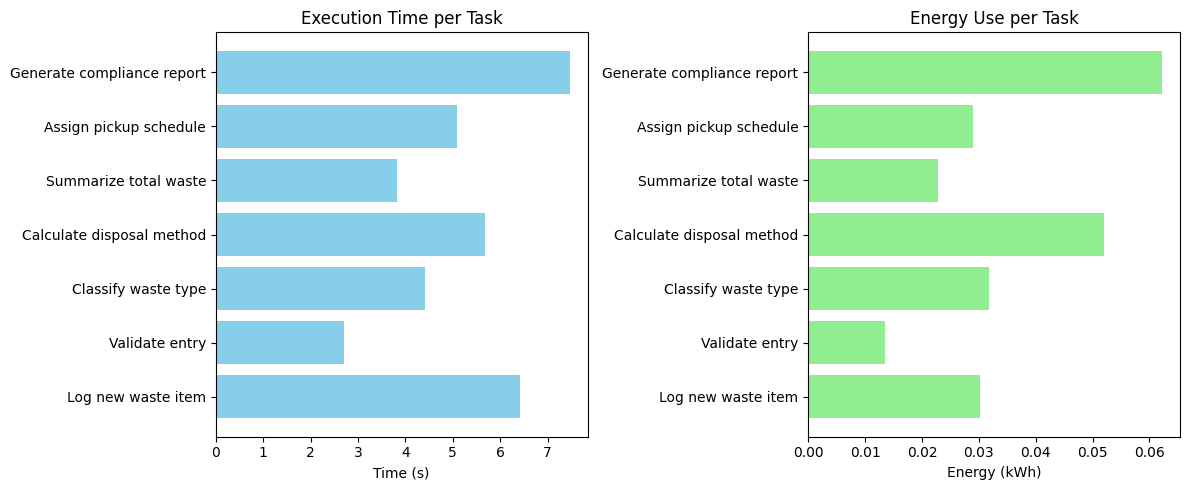

In [13]:
import matplotlib.pyplot as plt

# get values (skip last row which is TOTAL)
task_labels = [row['Task'] for row in results[:-1]]
times = [row['Time (s)'] for row in results[:-1]]
energy = [row['Energy (kWh)'] for row in results[:-1]]

plt.figure(figsize=(12, 5))

# Time per task
plt.subplot(1, 2, 1)
plt.barh(task_labels, times, color='skyblue')
plt.title("Execution Time per Task")
plt.xlabel("Time (s)")

# Energy per task
plt.subplot(1, 2, 2)
plt.barh(task_labels, energy, color='lightgreen')
plt.title("Energy Use per Task")
plt.xlabel("Energy (kWh)")

plt.tight_layout()
plt.show()


In [14]:
# make a copy of the original DAG
G_opt = G.copy()

# apply optimization: reduce time + cpu
for n in G_opt.nodes():
    G_opt.nodes[n]['exec_time'] = round(G_opt.nodes[n]['exec_time'] * random.uniform(0.6, 0.8), 2)
    G_opt.nodes[n]['cpu'] = round(G_opt.nodes[n]['cpu'] * random.uniform(0.6, 0.8), 2)

# run simulation on optimized version
order_opt = list(nx.topological_sort(G_opt))
total_time_opt = 0
total_energy_opt = 0
results_opt = []

for n in order_opt:
    t = G_opt.nodes[n]['exec_time']
    c = G_opt.nodes[n]['cpu']
    energy = (t / 3600) * c * 50

    total_time_opt += t
    total_energy_opt += energy

    results_opt.append({
        "Task": G_opt.nodes[n]['label'],
        "Time (s)": t,
        "CPU": c,
        "Energy (kWh)": round(energy, 6)
    })

results_opt.append({
    "Task": "TOTAL (Optimized)",
    "Time (s)": round(total_time_opt, 2),
    "CPU": "",
    "Energy (kWh)": round(total_energy_opt, 6)
})

# make a DataFrame to show
df_opt = pd.DataFrame(results_opt)
print(df_opt)


                         Task  Time (s)   CPU  Energy (kWh)
0          Log new waste item      4.96  0.23      0.015844
1              Validate entry      1.84  0.25      0.006389
2         Classify waste type      2.75  0.38      0.014514
3   Calculate disposal method      4.30  0.45      0.026875
4       Summarize total waste      2.79  0.27      0.010463
5      Assign pickup schedule      3.57   0.3      0.014875
6  Generate compliance report      4.91  0.46      0.031369
7           TOTAL (Optimized)     25.12            0.120329


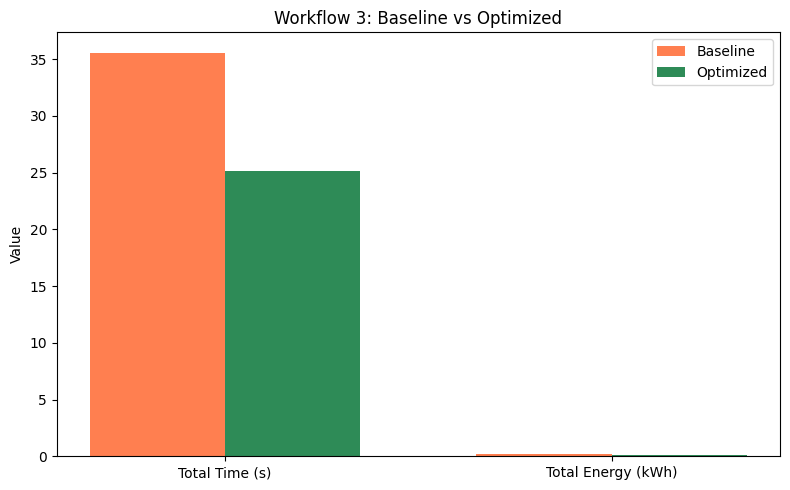

In [15]:
import numpy as np

# get totals from both DataFrames
base_time = df[df['Task'] == 'TOTAL']['Time (s)'].values[0]
base_energy = df[df['Task'] == 'TOTAL']['Energy (kWh)'].values[0]
opt_time = df_opt[df_opt['Task'] == 'TOTAL (Optimized)']['Time (s)'].values[0]
opt_energy = df_opt[df_opt['Task'] == 'TOTAL (Optimized)']['Energy (kWh)'].values[0]

# data
labels = ['Total Time (s)', 'Total Energy (kWh)']
baseline_vals = [base_time, base_energy]
optimized_vals = [opt_time, opt_energy]

x = np.arange(len(labels))
width = 0.35

# plot chart
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_vals, width, label='Baseline', color='coral')
plt.bar(x + width/2, optimized_vals, width, label='Optimized', color='seagreen')

plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Workflow 3: Baseline vs Optimized")
plt.legend()
plt.tight_layout()
plt.show()
